# Credit Card Transactions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
df1= pd.read_csv('cc_info.csv')
df2 = pd.read_csv('transactions.csv', parse_dates= ['date'])


In [4]:
df1.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [5]:
df2.head()
df2['date'].dtype

dtype('<M8[ns]')

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null datetime64[ns]
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB


In [7]:
df3 =pd.merge(df1, df2, on= 'credit_card', how = 'left')
df3.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099


In [8]:
#df3['date'] = pd.DatetimeIndex(df3['date']).month
#df3['date']
df3['date'] = pd.to_datetime(df3['date'])

In [9]:
df3['date'].dtype

dtype('<M8[ns]')

In [10]:
df3.sort_values(by = ['date'], inplace = True)
df3.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat
179840,9484591448272784,New Orleans,LA,70112,4000,2015-07-31 09:39:48,17.99,-90.045639,29.889039
240501,7053196367895112,New York,NY,10001,18000,2015-07-31 11:03:48,12.09,-74.027561,40.689615
255316,9528285469413252,Washington,NH,3280,40000,2015-07-31 11:10:14,78.21,-72.139485,43.108100
261083,1845720274833905,El Paso,IL,61738,20000,2015-07-31 11:28:55,74.41,-89.002148,40.804323
148163,7850942767136368,Washington,NH,3280,4000,2015-07-31 11:38:51,54.89,-72.025675,43.210753


In [11]:
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.dayofweek)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3.drop(['date'], axis = 1, inplace = True)

In [12]:
#df3['date'].resample('M', convention= 'start').asfreq()
df3.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,weekday,hour
179840,9484591448272784,New Orleans,LA,70112,4000,17.99,-90.045639,29.889039,7,31,4,9
240501,7053196367895112,New York,NY,10001,18000,12.09,-74.027561,40.689615,7,31,4,11
255316,9528285469413252,Washington,NH,3280,40000,78.21,-72.139485,43.108100,7,31,4,11
261083,1845720274833905,El Paso,IL,61738,20000,74.41,-89.002148,40.804323,7,31,4,11
148163,7850942767136368,Washington,NH,3280,4000,54.89,-72.025675,43.210753,7,31,4,11


In [13]:
def monthly_transactions(df):
    total_trans = df['transaction_dollar_amount'].sum()
    credit_limit = df['credit_card_limit'].values[0]
    return pd.Series([total_trans, credit_limit], index = ['total_transaction','credit_limit'])

In [14]:
#df3.groupby(['credit_card','month']).describe()
grouped = df3.groupby(['credit_card','month']).apply(monthly_transactions)
grouped = grouped.reset_index()
#grouped

In [15]:
lis_num = df3.groupby(['credit_card','month','credit_card_limit'])['transaction_dollar_amount'].agg('sum')
lis_num= pd.DataFrame(lis_num)
lis_num= lis_num.reset_index()
lis_num.head()


,credit_card,month,credit_card_limit,transaction_dollar_amount
0,1003715054175576,7,20000,162.56
1,1003715054175576,8,20000,8441.51
2,1003715054175576,9,20000,11281.56
3,1003715054175576,10,20000,8954.21
4,1013870087888817,7,15000,281.43


In [16]:
#### Calculate the credit cards which haven't exceed credit card limit
credit_count = lis_num.loc[lis_num['credit_card_limit']>=lis_num['transaction_dollar_amount'], 'credit_card' ]
#cred_num = credit_count.unique()
#credit_count
cred_num = pd.DataFrame(credit_count.groupby(credit_count).count().sort_values(ascending = False))
 #= cred_num.reset_index()

cred_num.columns = ['count_number'] 
cred_num= cred_num.reset_index()
list0 =cred_num.loc[cred_num['count_number']==4, 'credit_card']
print('\nnumber of credit cards which havent exceed limit:',len(list0))
list0.head()


number of credit cards which havent exceed limit: 751


0    1003715054175576
1    4546345297067747
2    5177967593503491
3    5175507030601876
4    5171595359553508
Name: credit_card, dtype: int64

In [17]:
df3.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,weekday,hour
179840,9484591448272784,New Orleans,LA,70112,4000,17.99,-90.045639,29.889039,7,31,4,9
240501,7053196367895112,New York,NY,10001,18000,12.09,-74.027561,40.689615,7,31,4,11
255316,9528285469413252,Washington,NH,3280,40000,78.21,-72.139485,43.108100,7,31,4,11
261083,1845720274833905,El Paso,IL,61738,20000,74.41,-89.002148,40.804323,7,31,4,11
148163,7850942767136368,Washington,NH,3280,4000,54.89,-72.025675,43.210753,7,31,4,11


In [18]:
df3['credit_card_limit'].values[0]

4000

In [19]:
def daily_surpass_limit(df, month, day):
   #df['credit_card']
    df0 = df.loc[(df['month']== month) & (df['day'] <=day),['credit_card','credit_card_limit','transaction_dollar_amount']]
    
    def sum_credit_card(dfn):
        
        return pd.Series([dfn['transaction_dollar_amount'].sum(), dfn['credit_card_limit'].values[0]],index= ['transction sum','limit'] )
    
    
    
    grouped2= df0.groupby(['credit_card']).apply(sum_credit_card)
    grouped2 = grouped2.reset_index()
    
    #df.loc[df['month']== month & df['day'] <=day,'transaction_dollar_amount'].sum()


    return grouped2[grouped2['transction sum']>grouped2['limit']]


daily_surpass_limit(df3, 8, 20)

,credit_card,transction sum,limit
194,2850146878241916,4012.81,4000.0
319,3936887050542904,5352.07,4000.0
341,4118286032166087,3416.52,3000.0
383,4462290711836916,3119.53,2000.0
525,5723635641134781,2161.30,2000.0
698,7299183791723634,7074.49,7000.0
772,7850942767136368,5704.00,4000.0
834,8522875529951473,5860.89,5000.0
874,8972201384562696,5266.08,5000.0


In [20]:
df3.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,weekday,hour
179840,9484591448272784,New Orleans,LA,70112,4000,17.99,-90.045639,29.889039,7,31,4,9
240501,7053196367895112,New York,NY,10001,18000,12.09,-74.027561,40.689615,7,31,4,11
255316,9528285469413252,Washington,NH,3280,40000,78.21,-72.139485,43.108100,7,31,4,11
261083,1845720274833905,El Paso,IL,61738,20000,74.41,-89.002148,40.804323,7,31,4,11
148163,7850942767136368,Washington,NH,3280,4000,54.89,-72.025675,43.210753,7,31,4,11


## Question 3
implement an unsupervised algorithm returning all transactions seem unusual

In [21]:
df4= df3
df3.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,weekday,hour
179840,9484591448272784,New Orleans,LA,70112,4000,17.99,-90.045639,29.889039,7,31,4,9
240501,7053196367895112,New York,NY,10001,18000,12.09,-74.027561,40.689615,7,31,4,11
255316,9528285469413252,Washington,NH,3280,40000,78.21,-72.139485,43.108100,7,31,4,11
261083,1845720274833905,El Paso,IL,61738,20000,74.41,-89.002148,40.804323,7,31,4,11
148163,7850942767136368,Washington,NH,3280,4000,54.89,-72.025675,43.210753,7,31,4,11


There are two ways to check whether a  transaction is unusual or not:
1. check the transaction dollar amount to the mean value, if it deviates a lot, then it could be a fraud
2. check the transaction place if it is far away from the usual places, then it is possible that it is a fraud. 
Since time is limited here, we will only talk about the transaction dollar amount case.

In [22]:
#df3.groupby(['credit_card'])['Long','Lat']
credit_cardn= df3['credit_card'].unique()

In [ ]:

#df3.plot(kind= 'scatter', x= 'Long',y = 'Lat',c= 'transaction_dollar_amount',cmap= plt.get_cmap('jet'),
         #colorbar= True, alpha = 0.4, figsize= (12,8))
#for cred in credit_cardn:
    
    #df3[df3['credit_card']== cred].plot(kind= 'scatter', x= 'Long',y = 'Lat', alpha = 0.4, figsize= (12,8))

In [24]:
def percent4(df):
    ps= [25,50,75]
    return pd.Series(np.percentile(df,ps),index = ['{}%'.format(p) for p in ps])
    


df3_stats= df3.groupby(['credit_card'])['transaction_dollar_amount'].apply(percent4).unstack()
df3_stats.head()

,25%,50%,75%
credit_card,,,
1003715054175576,59.01,93.73,124.63
1013870087888817,58.09,87.67,128.02
1023820165155391,55.43,85.78,122.83
1073931538936472,108.08,147.19,194.83
1077622576192810,122.93,148.18,160.11


In [25]:
temp = pd.merge(df3, df3_stats, how = 'left', left_on='credit_card',right_index=True)
temp.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,weekday,hour,25%,50%,75%
179840,9484591448272784,New Orleans,LA,70112,4000,17.99,-90.045639,29.889039,7,31,4,9,8.9975,12.410,16.9525
240501,7053196367895112,New York,NY,10001,18000,12.09,-74.027561,40.689615,7,31,4,11,45.0200,70.940,97.5000
255316,9528285469413252,Washington,NH,3280,40000,78.21,-72.139485,43.108100,7,31,4,11,82.2000,137.030,189.2300
261083,1845720274833905,El Paso,IL,61738,20000,74.41,-89.002148,40.804323,7,31,4,11,37.6825,61.335,84.6125
148163,7850942767136368,Washington,NH,3280,4000,54.89,-72.025675,43.210753,7,31,4,11,28.1400,45.850,64.2100


## Reduce dimension and visualize

In [33]:
temp0= temp.drop(['credit_card','city','state','zipcode','Long','Lat','month','day','weekday','hour'], axis= 1)
temp0.head()
X= temp0

In [34]:
temp0.head()

,credit_card_limit,transaction_dollar_amount,25%,50%,75%
179840,4000,17.99,8.9975,12.410,16.9525
240501,18000,12.09,45.0200,70.940,97.5000
255316,40000,78.21,82.2000,137.030,189.2300
261083,20000,74.41,37.6825,61.335,84.6125
148163,4000,54.89,28.1400,45.850,64.2100


In [35]:
temp0.to_csv('percentile_tansaction.csv')

In [36]:
X= scale(X)

In [37]:
pca= PCA(n_components = 2)
X2d = pca.fit_transform(X)
X2d = pd.DataFrame(X2d, columns= ['pc1','pc2'])

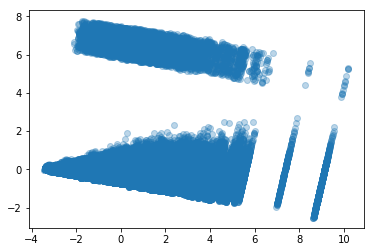

In [38]:
plt.scatter(X2d.pc1, X2d.pc2, alpha= 0.3)

In [40]:
k_means_fit = KMeans(n_clusters =6, max_iter= 300)
k_means_fit.fit(X)
#k_labels['label'] = k_means_fit.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [44]:
X2d['label'] = k_means_fit.labels_
X2d['label'].value_counts()
#X2d['label']

1    107348
3     73317
0     49215
5     33289
4     25983
2      5436
Name: label, dtype: int64

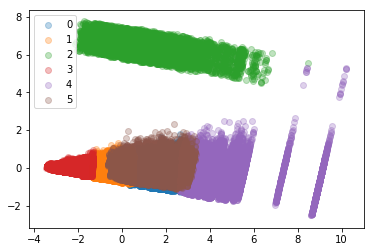

In [48]:
for label in range(6):
    plt.scatter(X2d[X2d['label']== label].pc1, X2d[X2d['label']== label].pc2, label= label, alpha= 0.3)
plt.legend()

## Check for suspicous activities

In [61]:
X2d['label'].value_counts()


1    107348
3     73317
0     49215
5     33289
4     25983
2      5436
Name: label, dtype: int64

In [79]:
suspcious_ac = temp[X2d['label'] ==2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [80]:
suspcious_ac.head(10)

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,weekday,hour,25%,50%,75%
170113,3709941163857886,Charlotte,VT,5445,21000,55.94,132.914611,-13.237867,7,31,4,15,38.7600,62.520,91.2800
36297,9449500138776236,Richmond,MA,1254,20000,118.11,-73.360473,42.337358,7,31,4,15,39.3150,63.790,86.3950
292621,1128536627506856,El Paso,IL,61738,16000,46.42,-88.973331,40.781931,7,31,4,16,50.4000,76.420,107.1900
14387,7649237198931106,Seattle,WA,98060,14000,92.55,-121.774773,47.447348,7,31,4,16,65.4500,106.640,148.2600
35069,8353267890887335,Washington,NH,3280,10000,54.45,-72.093403,43.166624,7,31,4,16,19.2350,29.590,40.3275
58661,3742680218482691,Washington,NH,3280,25000,124.65,-72.098015,43.249491,7,31,4,16,65.6450,108.260,159.2150
5968,9758203643408520,Washington,NH,3280,12000,6.02,-72.066343,43.140464,7,31,4,17,15.5225,23.130,31.9075
59096,7081424943873587,Washington,NH,3280,18000,15.30,-72.150266,43.184523,7,31,4,17,36.7650,58.980,82.9300
92930,9577424157559810,Huntington,MA,1050,18000,76.39,-72.852617,42.347951,7,31,4,17,43.4775,67.715,97.5075
3987,7869254138083290,Washington,NH,3280,10000,9.47,-72.084592,43.150889,7,31,4,17,34.0800,48.480,67.3400


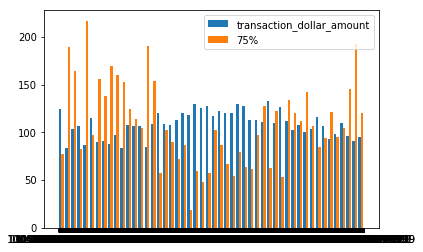

In [81]:
labels = ["transaction_dollar_amount",'75%']
plt.hist(suspcious_ac.loc[:,labels],label= labels, bins= 50)
plt.legend()